# Safe Learning for a Cart Pole System

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
import gpflow
import safe_learning
import matplotlib.pyplot as plt
import time
import os
import math

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
from utilities import CartPole, compute_closedloop_response, get_parameter_change, find_nearest, reward_rollout, compute_roa, binary_cmap
%matplotlib inline
# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

In [2]:
class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = safe_learning.config.np_dtype,
                  tf_dtype              = safe_learning.config.dtype,
                  saturate              = False,                            # apply saturation constraints to the control input
                  eps                   = 1e-8,                            # numerical tolerance
                  use_linear_dynamics   = True,                           # use the linearized form of the dynamics as the true dynamics (for testing)
                  dpi                   = 200,
                  num_cores             = 10,
                  num_sockets           = 2)


## TensorFlow Session

Customize the TensorFlow session for the current device.

In [3]:
# Start the session
# Open a new session (close old one if exists)


os.environ["KMP_BLOCKTIME"]    = str(0)
os.environ["KMP_SETTINGS"]     = str(1)
os.environ["KMP_AFFINITY"]     = 'granularity=fine,noverbose,compact,1,0'
os.environ["OMP_NUM_THREADS"]  = str(OPTIONS.num_cores*4)

config = tf.ConfigProto(intra_op_parallelism_threads  = OPTIONS.num_cores*4,
                        inter_op_parallelism_threads  = OPTIONS.num_sockets,
                        allow_soft_placement          = False,
                        device_count                  = {'CPU': OPTIONS.num_cores})

try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession(config=config)
session.run(tf.global_variables_initializer())

## Define underlying dynamic system and costs/rewards
Define the dynamics of the true and false system


In [4]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# True system parameters
m = 0.2    # pendulum mass
M = 1.0    # cart mass
L = 0.5    # pole length
b = 0.2     # rotational friction

# 'Wrong' model parameters
mw = 0.2    # pendulum mass
Mw = 1.0    # cart mass
Lw = 0.5    # pole length
bw = 0.0    # rotational friction

# State and action normalizers
x_max         = 0.5                                 # linear position [m]
theta_max     = np.deg2rad(30)                      # angular position [rad]
x_dot_max     = 2                                   # linear velocity [m/s]
theta_dot_max = np.deg2rad(30)                      # angular velocity [rad/s]
u_max         = (m + M) * (x_dot_max ** 2) / x_max  # linear force [N], control action

state_norm = (x_max, theta_max, x_dot_max, theta_dot_max)
action_norm = (u_max,)

# Dimensions and domains
state_dim     = 4
action_dim    = 1
state_limits  = np.array([[-math.pi, math.pi]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)
print(state_limits)
# Initialize system class and its linearization
true_dynamics = CartPole(m, M, L, b, dt, [state_norm, action_norm])
wrong_dynamics = CartPole(mw, Mw, Lw, bw, dt, [state_norm, action_norm])
    
# LQR cost matrices
Q = 0.1 * np.identity(state_dim).astype(OPTIONS.np_dtype)     # state cost matrix
R = 0.1 * np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix

# Quadratic reward/cost function
reward_function = safe_learning.QuadraticFunction(block_diag(- Q, - R), name='reward_function')

### Quadratic (LQR) reward function

#reward_function = safe_learning.QuadraticFunction(linalg.block_diag(-q, -r))

[[-3.14159265  3.14159265]
 [-3.14159265  3.14159265]
 [-3.14159265  3.14159265]
 [-3.14159265  3.14159265]]


In [5]:
mult = 1
n_states = [10, 20, 5, 10]
num_states = [i*mult for i in n_states]
# State grid
state_limits = np.array([[-1., 1.], ] * state_dim)

safety_disc = safe_learning.GridWorld(state_limits, num_states)
n_policy = [10, 10, 10, 10]
policy_disc = safe_learning.GridWorld(state_limits, [i for i in n_policy])

# Discretization constant
tau = np.min(safety_disc.unit_maxes)

pivot_state = np.asarray([0., 0., 0., 0.], dtype=OPTIONS.np_dtype)

# Snap pivot_state to the closest grid point
pivot_index = np.zeros_like(pivot_state, dtype=int)
for d in range(safety_disc.ndim):
    pivot_index[d], pivot_state[d] = find_nearest(safety_disc.discrete_points[d], pivot_state[d])

# Get 2d-planes of the discretization (x vs. v, theta vs. omega) according to pivot_state
planes = [[1, 3], [0, 2]]
safety_slices = []
for p in planes:
    safety_slices.append(np.logical_and(safety_disc.all_points[:, p[0]] == pivot_state[p[0]], 
                                      safety_disc.all_points[:, p[1]] == pivot_state[p[1]]).ravel())
print(safety_disc)
print('Grid size: {0}'.format(safety_disc.nindex))

# Snap pivot_state to the closest grid point
pivot_index = np.zeros_like(pivot_state, dtype=int)
for d in range(policy_disc.ndim):
    pivot_index[d], pivot_state[d] = find_nearest(policy_disc.discrete_points[d], pivot_state[d])

# Get 2d-planes of the discretization (x vs. v, theta vs. omega) according to pivot_state
planes = [[1, 3], [0, 2]]
policy_slices = []
for p in planes:
    policy_slices.append(np.logical_and(policy_disc.all_points[:, p[0]] == pivot_state[p[0]], 
                                      policy_disc.all_points[:, p[1]] == pivot_state[p[1]]).ravel())
print((policy_disc))
print('Grid size: {0}'.format(policy_disc.nindex))

Grid size: 10000
Grid size: 10000


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


### LQR init policy

## Define the GP dynamics model

We use a combination of kernels to model the errors in the dynamics

In [6]:
A, B = wrong_dynamics.linearize()
lipschitz_dynamics = 1
print(np.shape(A))
print(np.shape(B))
noise_var = 0.001 ** 2

m_true = np.hstack((true_dynamics.linearize()))
m = np.hstack((A, B))

variances = (m_true - m) ** 2
print(variances)
# Input to GP is of the form (x, u) = (state, action)
full_dim = state_dim + action_dim
# Make sure things remain 
np.clip(variances, 1e-5, None, out=variances)

# Kernels (just linear for now)
kernel1 = (gpflow.kernels.Linear(full_dim, variance=variances[0, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[0, 3]))

kernel2 = (gpflow.kernels.Linear(full_dim, variance=variances[1, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[1, 3]))

kernel3 = (gpflow.kernels.Linear(full_dim, variance=variances[2, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[2, 3]))

kernel4 = (gpflow.kernels.Linear(full_dim, variance=variances[3, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[3, 3]))

# Mean dynamics

mean_dynamics = safe_learning.LinearSystem((A, B), name='mean_dynamics')
mean_function1 = safe_learning.LinearSystem((A[[0], :], B[[0], :]), name='mean_dynamics_1')
mean_function2 = safe_learning.LinearSystem((A[[1], :], B[[1], :]), name='mean_dynamics_2')
mean_function3 = safe_learning.LinearSystem((A[[2], :], B[[2], :]), name='mean_dynamics_3')
mean_function4 = safe_learning.LinearSystem((A[[3], :], B[[3], :]), name='mean_dynamics_4')

# Define a GP model over the dynamics
X_init   = np.zeros((1, full_dim), dtype=OPTIONS.np_dtype)
Y_init   = np.zeros((1, 1), dtype=OPTIONS.np_dtype)

gp1 = gpflow.gpr.GPR(X_init,
                    Y_init,
                    kernel1,
                    mean_function=mean_function1)
gp1.likelihood.variance = noise_var

gp2 = gpflow.gpr.GPR(X_init,
                    Y_init,
                    kernel2,
                    mean_function=mean_function2)
gp2.likelihood.variance = noise_var

gp3 = gpflow.gpr.GPR(X_init,
                    Y_init,
                    kernel3,
                    mean_function=mean_function3)
gp3.likelihood.variance = noise_var

gp4 = gpflow.gpr.GPR(X_init,
                    Y_init,
                    kernel4,
                    mean_function=mean_function4)
gp4.likelihood.variance = noise_var


gp1_fun = safe_learning.GaussianProcess(gp1)
gp2_fun = safe_learning.GaussianProcess(gp2)
gp3_fun = safe_learning.GaussianProcess(gp3)
gp4_fun = safe_learning.GaussianProcess(gp4)

dynamics = safe_learning.FunctionStack((gp1_fun, gp2_fun, gp3_fun, gp4_fun))

/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


(4, 4)
(4, 1)
[[0.00000000e+00 2.63908917e-12 0.00000000e+00 4.25222878e-10
  6.40175101e-12]
 [0.00000000e+00 3.46544747e-10 0.00000000e+00 5.58369746e-08
  8.40628355e-10]
 [0.00000000e+00 1.47318449e-08 0.00000000e+00 1.04708054e-06
  3.57356638e-08]
 [0.00000000e+00 3.09515482e-05 0.00000000e+00 2.19991208e-03
  7.50804889e-05]]


In [7]:
# Compute the optimal policy for the linear (and wrong) mean dynamics
k, s = safe_learning.utilities.dlqr(A, B, Q, R)
init_policy = safe_learning.LinearSystem((-k), name='initial_policy')
init_policy = safe_learning.Saturation(init_policy, -1, 1)

# Define the Lyapunov function corresponding to the initial policy
init_lyapunov = safe_learning.QuadraticFunction(s)

## Set up the dynamic programming problem

In [8]:
# Define a neural network policy
layer_dims = [32, 32, 32, 32, action_dim]
activations = [tf.nn.relu, tf.nn.relu, None]
if OPTIONS.saturate:
    activations[-1] = tf.nn.tanh
policy = safe_learning.functions.NeuralNetwork(layer_dims, activations, name='policy', use_bias=False)

# Define value function approximation
value_function = safe_learning.Triangulation(policy_disc,
                                             -init_lyapunov(policy_disc.all_points).eval(),
                                             project=True)


# Define policy optimization problem
rl = safe_learning.PolicyIteration(
    policy,
    dynamics,
    reward_function,
    value_function,
    gamma=0.98)
    

with tf.name_scope('rl_mean_optimization'):
    rl_opt_value_function = rl.optimize_value_function()
    
    # Placeholder for states
    tf_states_mean = tf.placeholder(OPTIONS.tf_dtype, [None, state_dim])
    
    # Optimize for expected gain
    values = rl.future_values(tf_states_mean)
    policy_loss = -tf.reduce_mean(values)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    adapt_policy_mean = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
# Start the session
session.run(tf.global_variables_initializer())

### Run initial dynamic programming for the mean dynamics

In [10]:
for i in tqdm(range(1000)):
    
    # select random training batches
    rl.feed_dict[tf_states_mean] = policy_disc.sample_continuous(100)

    session.run(adapt_policy_mean, feed_dict=rl.feed_dict)

## Define the Lyapunov function

Here we use the fact that the optimal value function is a Lyapunov function for the optimal policy if the dynamics are deterministic. As uncertainty about the dynamics decreases, the value function for the mean dynamics will thus converge to a Lyapunov function.

### Set up a discretization for safety verification

In [11]:
lyapunov_function = -rl.value_function
lipschitz_lyapunov = lambda x: tf.reduce_max(tf.abs(rl.value_function.gradient(x)),
                                             axis=1, keepdims=True)

lipschitz_policy = lambda x: policy.lipschitz() 

a_true, b_true = true_dynamics.linearize()
lipschitz_dynamics = lambda x: np.max(np.abs(a_true)) + np.max(np.abs(b_true)) * lipschitz_policy(x)

# Lyapunov function definitial
lyapunov = safe_learning.Lyapunov(safety_disc,
                                  lyapunov_function,
                                  dynamics,
                                  lipschitz_dynamics,
                                  lipschitz_lyapunov,
                                  tau,
                                  policy=rl.policy,
                                  initial_set=None)

# Set initial safe set (level set) based on initial Lyapunov candidate
values = init_lyapunov(safety_disc.all_points).eval()
cutoff = np.max(values) * 0.005

lyapunov.initial_safe_set = np.squeeze(values, axis=1) <= cutoff

In [12]:
def plot_safe_set(lyapunov, show=True):
    """Plot the safe set for a given Lyapunov function."""
    plt.imshow(lyapunov.safe_set.reshape(num_states).T,
               origin='lower',
               extent=lyapunov.discretization.limits.ravel(),
               vmin=0,
               vmax=1)
    
    if isinstance(lyapunov.dynamics, safe_learning.UncertainFunction):
        X = lyapunov.dynamics.functions[0].X
        plt.plot(X[:, 0], X[:, 1], 'rx')
    
    plt.title('safe set')
    plt.colorbar()
    if show:
        plt.show()
    
lyapunov.update_safe_set()
#plot_safe_set(lyapunov)

## Safe policy update

We do dynamic programming, but enfore the decrease condition on the Lyapunov function using a Lagrange multiplier

In [13]:
with tf.name_scope('policy_optimization'):
    
    # Placeholder for states
    tf_states = tf.placeholder(safe_learning.config.dtype, [None, state_dim])
    
    # Add Lyapunov uncertainty (but only if safety-relevant)
    values = rl.future_values(tf_states, lyapunov=lyapunov)
    
    policy_loss = -tf.reduce_mean(values)
    

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    adapt_policy = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)
    
    
def rl_optimize_policy(num_iter):
    # Optimize value function
    session.run(rl_opt_value_function, feed_dict=rl.feed_dict)

    # select random training batches
    for i in tqdm(range(num_iter)):
        rl.feed_dict[tf_states] = lyapunov.discretization.sample_continuous(1000)

        session.run(adapt_policy, feed_dict=rl.feed_dict)

# Exploration

We explore close to the current policy by sampling the most uncertain state that does not leave the current level set

In [14]:
action_variation = np.array([[-0.05], [0.], [0.05]], dtype=OPTIONS.np_dtype)


with tf.name_scope('add_new_measurement'):
        tf_max_state_action = tf.placeholder(OPTIONS.tf_dtype,
                                             shape=[1, full_dim])
        tf_measurement = true_dynamics(tf_max_state_action)
        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Get a new sample location
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits,
                                                        num_samples=1000)

    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)

    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)
    

# Run the optimization

In [22]:
# lyapunov.update_safe_set()
rl_optimize_policy(num_iter=100)
rl_optimize_policy(num_iter=100)


In [23]:
#lyapunov.update_safe_set()
#print(lyapunov)
#plot_safe_set(lyapunov)

In [24]:
for i in range(5):
    print('iteration {} with c_max: {}'.format(i, lyapunov.feed_dict[lyapunov.c_max]))
    for i in tqdm(range(10)):
        update_gp()
    
    rl_optimize_policy(num_iter=100)
    lyapunov.update_values()
    
    # Update safe set and plot
    #lyapunov.update_safe_set()
    #plot_safe_set(lyapunov)    

iteration 0 with c_max: -2.3158202017107845
iteration 1 with c_max: -2.3158202017107845
iteration 2 with c_max: -2.3158202017107845
iteration 3 with c_max: -2.3158202017107845
iteration 4 with c_max: -2.3158202017107845


# Plot trajectories and analyse improvement

In [25]:
x0 = np.array([[math.pi*0.5, -0.0, 0.0, 0.0]])

states_new, actions_new = safe_learning.utilities.compute_trajectory(true_dynamics, rl.policy, x0, 1000)
states_old, actions_old = safe_learning.utilities.compute_trajectory(true_dynamics, init_policy, x0, 1000)

t = np.arange(len(states_old)) * true_dynamics.dt

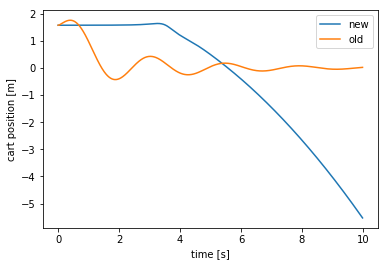

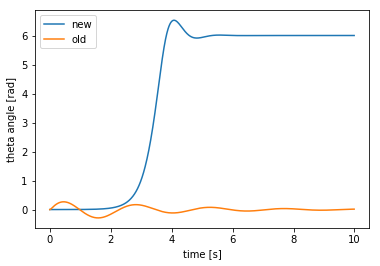

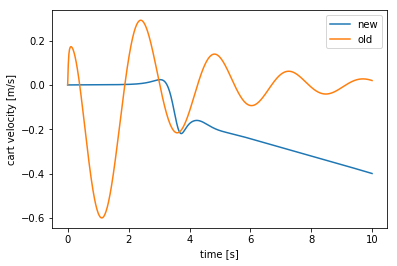

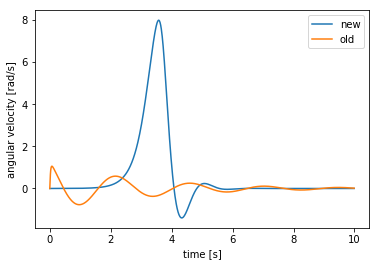

In [26]:
plt.plot(t, states_new[:, 0], label='new')
plt.plot(t, states_old[:, 0], label='old')
plt.xlabel('time [s]')
plt.ylabel('cart position [m]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 1], label='new')
plt.plot(t, states_old[:, 1], label='old')
plt.xlabel('time [s]')
plt.ylabel('theta angle [rad]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 2], label='new')
plt.plot(t, states_old[:, 2], label='old')
plt.xlabel('time [s]')
plt.ylabel('cart velocity [m/s]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 3], label='new')
plt.plot(t, states_old[:, 3], label='old')
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rad/s]')
plt.legend()
plt.show()

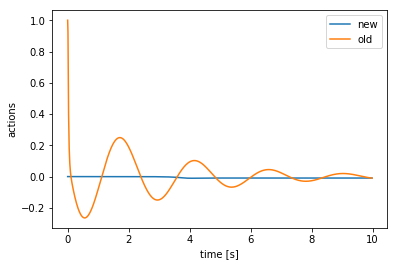

In [27]:
plt.plot(t[:-1], actions_new, label='new')
plt.plot(t[:-1], actions_old, label='old')
plt.xlabel('time [s]')
plt.ylabel('actions')
plt.legend()

In [28]:
print('reward old:', tf.reduce_sum(rl.reward_function(states_old[:-1], actions_old)).eval(feed_dict=rl.feed_dict))
print('reward new:', tf.reduce_sum(rl.reward_function(states_new[:-1], actions_new)).eval(feed_dict=rl.feed_dict))

reward old: -44.08159190363232
reward new: -3222.9008273435393
